In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from sympy import diff,solve
from itertools import count

In [2]:
def full_grid(g_a,g_b,g_L,T,A = 0):
    X, x_a, x_b, x_L, z_a, z_b = sy.symbols('X, x_a, x_b, x_L, z_a, z_b')
    
    def beta_L(A):
        eq1 = (-diff(g_L) + diff(g_b))
        eq2 = (-diff(g_b) + (g_b - g_L)/(x_b - x_L))
        sol = solve((eq1,eq2),[x_b,x_L])

        x_b_,x_L_ = sol[0][0],sol[0][1]
        z_b_ = (X - x_L_)/(x_b_ - x_L_)
        z_L_ = 1 - z_b_
        return z_b_*g_b.subs(x_b, x_b_) + z_L_*g_L.subs(x_L, x_L_)

    def alpha_L(A):
        eq1 = (-diff(g_L) + diff(g_a))
        eq2 = (-diff(g_a) + (g_a - g_L)/(x_a - x_L))
        sol = solve((eq1,eq2),[x_a,x_L])

        x_a_,x_L_ = sol[0][0],sol[0][1]
        z_a_ = (X - x_L_)/(x_a_ - x_L_)
        z_L_ = 1 - z_a_
        return z_a_*g_a.subs(x_a, x_a_) + z_L_*g_L.subs(x_L, x_L_)

    def alpha_beta(A):
        eq1 = (-diff(g_a) + diff(g_b))
        eq2 = (-diff(g_b) + (g_b - g_a + A*(1-2*(x_a-X)/(x_a-x_b)))/(x_b - x_a))
        sol = solve((eq1,eq2),[x_a,x_b])

        x_a_,x_b_ = sol[0][0],sol[0][1]
        z_a_ = (X - x_b_)/(x_a_ - x_b_)
        z_b_ = 1 - z_a_
        return z_a_*g_a.subs(x_a,x_a_) + z_b_*g_b.subs(x_b,x_b_) + A*z_a_*z_b_ 
    
    def alpha_beta_L(A): #Delete out? 
        eq1 = (-diff(g_a) + diff(g_b))
        eq2 = (-diff(g_b) + diff(g_L))
        eq3 = (-diff(g_L) + (g_a - g_L + A*z_b)/(x_a - x_L))
        eq4 = (-diff(g_L) + (g_b - g_L + A*z_a)/(x_b - x_L))
        eq5 = (X - ((1-z_a-z_b)*x_L + z_a*x_a + z_b*x_b))
        sol = solve((eq1,eq2,eq3,eq4,eq5),[x_a,x_b,x_L,z_a,z_b])

        if np.size(sol) == 0:
            return float('inf')
        else:
            x_a_,x_b_,x_L_ = sol[0][0],sol[0][1],sol[0][2]
            z_a_,z_b_ = sol[0][3],sol[0][4]
            z_L_ = 1-z_a_-z_b_
        return z_a_*g_a.subs(x_a,x_a_) + z_b_*g_b.subs(x_b,x_b_) + z_L_*g_L.subs(x_L,x_L_) + A*z_a_*z_b_
    
#input the common tangent and 2 free energy functions
#returns the feasible boundaries    
    def inter_tan_G(com_tan,g_1,g_2,x_1,x_2):
        eq1 = (com_tan - g_1.subs(x_1,X))
        sol_1 = solve((eq1),[X])
        eq2 = (com_tan - g_2.subs(x_2,X))
        sol_2 = solve((eq2),[X])
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])

#Create new common tangents that obey the feasible boundaries
# and are infinity elsewhere
    def correct_tangent(com_tan,intersection_G):
        new_tangent = sy.Piecewise(
            (float('inf'),X <= min(intersection_G) -1e-8), #account for some error
            (float('inf'),X >= max(intersection_G)+1e-8),
            (com_tan,True))
        return new_tangent
    
#Find the boundaries which the common tangents intersect
    def intersect_com_tans(com_tan_1,com_tan_2):
        eq1 = (com_tan_1 - com_tan_2)
        sol = np.array(solve((eq1),[X]))
        return sol[np.where((sol > 0)&(sol < 1))]

    def intersect_abl(com_abl,com_al,com_bl): #delete out? 
        eq1 = (com_abl - com_al)
        sol_1 = solve((eq1),[X])
        if np.size(sol_1) == 0:
            sol_1 = [float('inf')]
        eq2 = (com_abl - com_bl)
        sol_2 = solve((eq2),[X])
        if np.size(sol_2) == 0:
            sol_2 = [float('inf')]
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])
    
    def correct_tangent_abl(com_tan,intersect_abl,al_G,bl_G):
        if min(al_G) <= intersect_abl[0] <= max(al_G):
            new_tangent = sy.Piecewise(
                (float('inf'),X <= min(intersect_abl) -1e-8), #account for some error
                (float('inf'),X >= max(intersect_abl)+1e-8),
                (com_tan,True))
        else:
            new_tangent = sy.Piecewise(
                (float('inf'),X <= 1 ), #account for some error
                (float('inf'),X >= 0))
        return new_tangent
    
    ##Find all of the points where a common tangent touches free energies and crosses other common tangents
    al_G = inter_tan_G(alpha_L(A),g_a,g_L,x_a,x_L)
    bl_G = inter_tan_G(beta_L(A),g_b,g_L,x_b,x_L)
    ab_G = inter_tan_G(alpha_beta(A),g_a,g_b,x_a,x_b)
    com_bl = correct_tangent(beta_L(A),bl_G)
    com_al = correct_tangent(alpha_L(A),al_G)
    com_ab = correct_tangent(alpha_beta(A),ab_G)
    al_bl = intersect_com_tans(com_al,com_bl)
    al_ab = intersect_com_tans(com_al,com_ab)
    ab_bl = intersect_com_tans(com_ab,com_bl)
    #Handle the three phase last
    #First finds the intersections
    abl_al_bl = intersect_abl(alpha_beta_L(A),alpha_L(A),beta_L(A))
    # computes the common tangent in feasible region 
    com_abl = correct_tangent_abl(alpha_beta_L(A),abl_al_bl,al_G,bl_G)
    # #add end points to full grid
    ends = np.array([0,1])
    grid_start = np.sort(np.concatenate((al_G,bl_G,ab_G,al_bl,al_ab,ab_bl,abl_al_bl)))
    grid_start = grid_start[np.where((0 < grid_start)&(1 > grid_start))]
    #create full grid to look (1e-# is to account for the minor errors and equal values at a point)
    grid_x = np.sort(np.concatenate((grid_start,grid_start*(1-1e-6),grid_start*(1+1e-6),ends)))

    ##Takes in the points and checks the phases of each point
    def check_phase(check_points,com_al,com_bl,com_ab,com_abl):
        phases = np.array(['αL','βL','αβ','αβL','α','β','L'])
        exit = []
        G_L = sy.lambdify(x_L,g_L)
        G_a = sy.lambdify(x_a,g_a)
        G_b = sy.lambdify(x_b,g_b)
        al_tangent = sy.lambdify(X,com_al)
        bl_tangent = sy.lambdify(X,com_bl)
        ab_tangent = sy.lambdify(X,com_ab)
        abl_tangent = sy.lambdify(X,com_abl)
        for i,val in enumerate(check_points):
            L = G_L(val)
            a = G_a(val)
            b = G_b(val)
            al = al_tangent(val)
            bl = bl_tangent(val)
            ab = ab_tangent(val)
            abl = abl_tangent(val)
            check = np.array([al,bl,ab,abl,a,b,L])
            index = np.argmin(check)
            exit.append(phases[index])
        return dict(zip(check_points,exit))
    
    plotting = check_phase(grid_x,com_al,com_bl,com_ab,com_abl) 
    
    #Takes in phases i.e. np.array(['αL','βL','αβ','α','β','L']), and result from check_phase, returns where phase begins
    def simplify_plot_points(phases,check_phase):
        vals = check_phase.values()
        keys = check_phase.keys()
        indexes = []
        for k in range(len(phases)):
            zipped = [i for i,j in zip(count(), plotting.values()) if j == phases[k]]
            if np.size(zipped) > 0:
                indexes.append(min(zipped))
        indexes = np.sort(indexes)
        return dict(zip(np.asarray(list(keys))[indexes],np.asarray(list(vals))[indexes]))
    
    phases = np.array(['αL','βL','αβ','αβL','α','β','L'])
    
    return {T:simplify_plot_points(phases,plotting)},com_al,com_bl,com_ab,com_abl

In [3]:
X,x_a, x_b, x_L= sy.symbols('X,x_a, x_b, x_L')
a = 30
x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,10.5
T = 1
g_a = a*(x_a-x_a0)**2 + b_a
g_b = a*(x_b-x_b0)**2 + b_b
g_L = a*(x_L-x_L0)**2 + b_L - T

return_all = full_grid(g_a,g_b,g_L,0,A = 0)

In [5]:
return_all[0]

{0: {0: 'α', 0.213889102777778: 'αβ', 0.813888888888889: 'β'}}

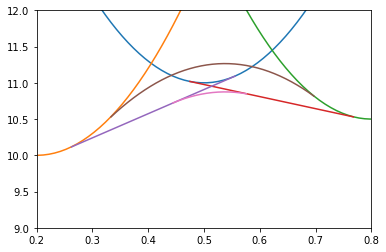

In [48]:
##Plot at specific T
common_al_ = sy.lambdify(X,return_all[1])
common_bl_ = sy.lambdify(X,return_all[2])
common_ab_ = sy.lambdify(X,return_all[3])
common_abl_ = sy.lambdify(X,return_all[4])

g_L_ = lambda x_L: a*(x_L-x_L0)**2 + b_L - 1
g_a_ = lambda x_a: a*(x_a-x_a0)**2 + b_a
g_b_ = lambda x_b: a*(x_b-x_b0)**2 + b_b

x = np.linspace(0,1,100)
plt.plot(x,g_L_(x))
plt.plot(x,g_a_(x))
plt.plot(x,g_b_(x))
plt.plot(x,common_bl_(x))
plt.plot(x,common_al_(x))
plt.plot(x,common_ab_(x))
plt.plot(x,common_abl_(x))
plt.ylim(9,12)
plt.xlim(.2,.8)
plt.show()

In [10]:
x_a, x_b, x_L = sy.symbols('x_a, x_b, x_L')

x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,10.5
a = 40
T_grid = np.linspace(0,2,10)
master_plot = {}
g_a = a*(x_a-x_a0)**2 + b_a
g_b = a*(x_b-x_b0)**2 + b_b
for i in range(len(T_grid)):
    T = T_grid[i]
    g_L = a*(x_L-x_L0)**2 + b_L - T
    master_plot.update(full_grid(g_a,g_b,g_L,T,A = 2)[0])

In [11]:
master_plot

{0.0: {0: 'α', 0.269444444444445: 'αβ', 0.758334091666667: 'β'},
 0.2222222222222222: {0: 'α', 0.269444444444445: 'αβ', 0.758334091666667: 'β'},
 0.4444444444444444: {0: 'α', 0.269444444444445: 'αβ', 0.758334091666667: 'β'},
 0.6666666666666666: {0: 'α', 0.269444444444445: 'αβ', 0.758334091666667: 'β'},
 0.8888888888888888: {0: 'α',
  0.261728654367724: 'αL',
  0.303395341374781: 'αβL',
  0.724382716049383: 'βL',
  0.766049382716049: 'β'},
 1.1111111111111112: {0: 'α',
  0.249382716049383: 'αL',
  0.357716351221070: 'αβL',
  0.670061666472182: 'βL',
  0.778395840123457: 'β'},
 1.3333333333333333: {0: 'α',
  0.237037035865823: 'αL',
  0.412036966591606: 'αβL',
  0.615740675836499: 'βL',
  0.790741525987996: 'β'},
 1.5555555555555554: {0: 'α',
  0.224691577178350: 'αL',
  0.466358424873662: 'αβL',
  0.561420238610833: 'βL',
  0.803086416059685: 'β'},
 1.7777777777777777: {0: 'α',
  0.212345891358025: 'αL',
  0.512345674739242: 'L',
  0.515432604023191: 'βL',
  0.815432902079337: 'β'},
 2